# ICR w/ XGBoost

Competition: Identifying Age-Related Conditions ([Link](https://www.kaggle.com/competitions/icr-identify-age-related-conditions))

Linked from Kaggle Notebook. Created by Hoang Vu.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from keras import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import optuna
from optuna.visualization import plot_param_importances


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [2]:
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')

### Data Visualization

In [3]:
train.head(5)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


/tmp/ipykernel_24/1384073362.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr())


<Axes: >

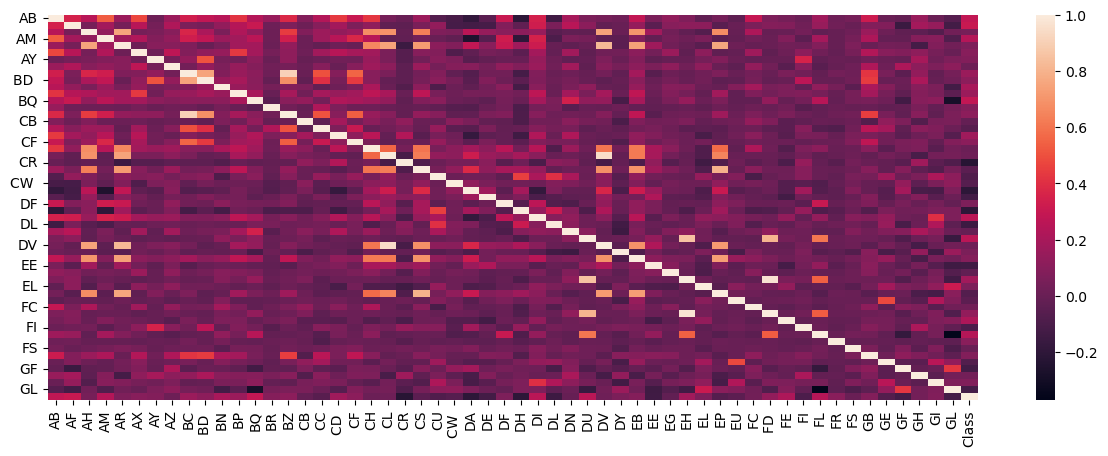

In [4]:
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(train.corr())

In [5]:
print(train.columns)

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')


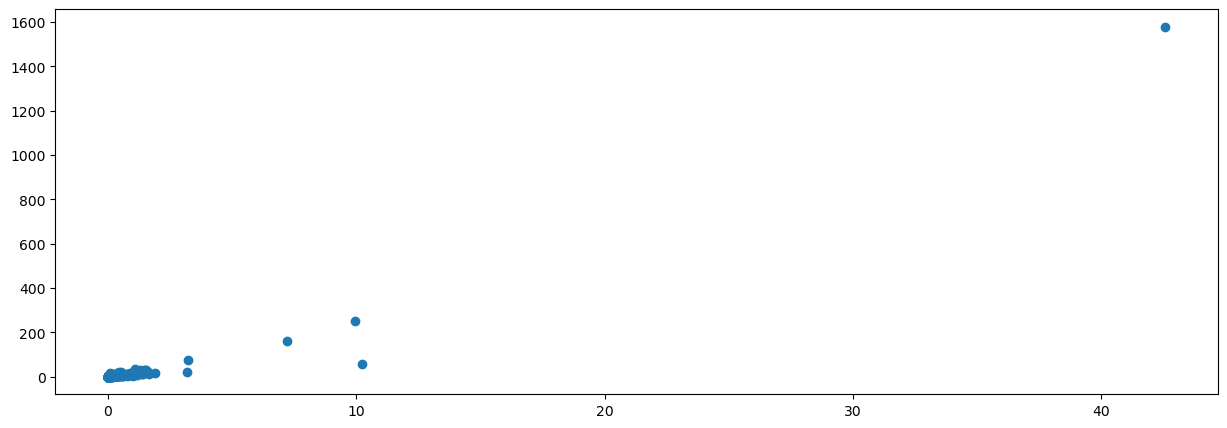

In [6]:
# closely correlated: CL & DV, EH & FD
one = train.loc[:,['CL', 'DV']]
two = train.loc[:, ['EH', 'FD ']]

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(two.EH, two['FD '])

In [7]:
train.isnull().sum()

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

<Axes: ylabel='Class'>

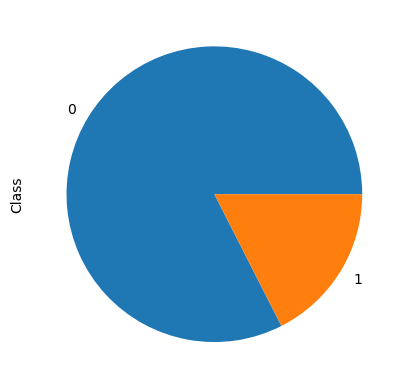

In [8]:
plot_train = train.Class.value_counts()
plot_train.plot(kind = 'pie')

### Data Pre-processing

In [9]:
X_train = train.drop(columns=['Id', 'Class'])
y_train = train.loc[:, ['Class']]

# Manually remove columns

num_col = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_col = ['EJ']

# Use OneHotEncoder for categorical columns

ohc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
enc_data = pd.DataFrame(ohc.fit_transform(X_train[cat_col]), columns=ohc.get_feature_names_out())

# Create new DataFrame using old DataFrame and encoded data (categorical columns are put at last)
X_train = X_train.drop(columns=cat_col).join(enc_data)

# Do the same with test data

Ids = test['Id']
X_test = test.drop(columns=['Id'])

enc_data = pd.DataFrame(ohc.transform(X_test[cat_col]), columns=ohc.get_feature_names_out())
X_test = X_test.drop(columns=cat_col).join(enc_data)

print(X_train.shape)
print(X_test.shape)

(617, 57)
(5, 57)


In [10]:
# SimpleImputer median

num_col = X_train.select_dtypes(exclude=['object']).columns.tolist()

med_imp = SimpleImputer(missing_values=np.nan, strategy='median')
X_train = pd.DataFrame(med_imp.fit_transform(X_train[num_col]), columns=num_col)

In [11]:
X_train.shape

(617, 57)

### XGBoost: Hyperparameter tuning & defining model

In [12]:
# Defining KFold

skf = StratifiedKFold(n_splits=5)

In [13]:
# Define objective function

def objective(trial):
    param = {  
        'tree_method': 'gpu_hist',
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('lambda', 0, 10.0),
        'alpha': trial.suggest_float('alpha', 0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.2,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree', 1, 1),
        #'early_stopping_rounds':200,
        }
    
    results=[]
    
    for train_index, test_index in skf.split(X_train, y_train):
        train_X, valid_X = X_train.iloc[train_index], X_train.iloc[test_index]
        train_y, valid_y = y_train.iloc[train_index], y_train.iloc[test_index]
        
        model = XGBClassifier(**param).fit(train_X, train_y,
                                           verbose=0)  
        
        # Predictions give probability of class=1
        pred = model.predict(valid_X)
        result = log_loss(valid_y, pred)
        results.append(result)
          
    n=sum(results)/len(results) 
    return n

# Log Loss --> The minimal it is the better

In [14]:
# Optimization function using Optuna (set direction to minimize since the eval metric is log loss)

study = optuna.create_study(direction='minimize')

# Remove the tag to make things work
# study.optimize(objective, n_trials = 50)
# study.best_params

[I 2023-09-10 00:03:39,387] A new study created in memory with name: no-name-48b71e11-c140-4d7d-a8c8-7756a4879175


In [15]:
# Remove the tag to make things work
#  fig = plot_param_importances(study)
#  fig.show()

### Make predictions

In [16]:
# params from hyperparameter tuning
best_params = {'tree_method': 'gpu_hist',
                'objective': 'binary:logistic',
                'eval_metric': 'logloss',
                'lambda': 3.6544643746800034,
                 'alpha': 0.8091866982683935,
                 'colsample_bytree': 0.6123420359535653,
                 'subsample': 0.9274960357629272,
                 'learning_rate': 0.04477043318988813,
                 'n_estimators': 2681,
                 'max_depth': 9,
                 'min_child_weight': 2,
                 'num_parallel_tree': 1}

model = XGBClassifier(**best_params).fit(X_train, y_train)

pred = model.predict_proba(X_test)

In [17]:
print(pred)

[[0.76388735 0.23611267]
 [0.76388735 0.23611267]
 [0.76388735 0.23611267]
 [0.76388735 0.23611267]
 [0.76388735 0.23611267]]


### Submit predictions

In [18]:
sample_submission.head()

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


In [19]:
sample_submission[['class_0', 'class_1']] = pred

In [20]:
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)